In [1]:
import sys, os
print (sys.version)
import cv2, math
import time
from matplotlib import pyplot as plt
import signal
import numpy as np
import multiprocessing
import threading
from threading import RLock


print(cv2.__file__)
%matplotlib notebook

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
/home/yousof/Software/programming/anaconda3/envs/python36/lib/python3.6/site-packages/cv2.cpython-36m-x86_64-linux-gnu.so


# Import and Setup OpenPose

In [2]:
openPoseDir = "/home/yousof/AI/openpose/"
openPoseLib = openPoseDir + "build/python"
sys.path.append(openPoseLib);
from openpose import pyopenpose as op
import openpose

params = dict()
params["model_folder"] = openPoseDir + "models"
params["hand"] = True
params["hand_detector"] = 0

In [3]:
def plotOpenCVImage(img):
    plt.figure(figsize=(10,18))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# Initialize OpenPose

In [4]:
opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()

In [5]:
def pointsToDegrees(d):
    BaseIdx = 5
    midIdx = 6
    tipIdx = 8
    hand = 0
    if d.handKeypoints[hand].size != 1:
        points = d.handKeypoints[hand][0, :, :].squeeze()
        all_zeros = not np.any(points)
        if not all_zeros:
            points[:, 1] = d.cvOutputData.shape[1] - points[:, 1]
            dy = points[midIdx, 1] - points[BaseIdx, 1]
            dx = points[midIdx, 0] - points[BaseIdx, 0]
            deg1 = math.degrees(math.atan2(dy, dx))
            dy = points[tipIdx, 1] - points[midIdx, 1]
            dx = points[tipIdx, 0] - points[midIdx, 0]
            deg2 = math.degrees(math.atan2(dy, dx))
            print(deg1 - 90, deg2)
            return deg1- 90 , deg2
    
def processImage(img):
    global  opWrapper
    datum = op.Datum()
    datum.cvInputData = img
    opWrapper.emplaceAndPop([datum])
    degs = pointsToDegrees(datum)
    return datum, degs

# Read from webcam

In [6]:
bufferLock = RLock()
image = None
isNewImage = False
running = True
def readImages():
    global running, image, isNewImage, bufferLock, cam
    cam = cv2.VideoCapture(0)
    cam.set(3 , 640  ) # width         1920
    cam.set(4 , 480  ) # height        1080      
    print("cam.isOpened()", cam.isOpened())
    while cam.isOpened() and running:
        ret, img = cam.read()
        if ret:
            bufferLock.acquire()
            isNewImage = True
            image = img.copy()
            bufferLock.release()
        else:
            break
    print("Releasing Camera!")
    cam.release()

imageReaderThread = threading.Thread(target=readImages)

In [7]:
def signal_handler(signal, frame):
    global running
    running = False
    
signal.signal(signal.SIGINT, signal_handler)

<function _signal.default_int_handler>

In [8]:
imageReaderThread.start()

In [9]:
def captureLastFrame():
    global image, isNewImage, bufferLock
    lastFrame = None
    suc = False
    if isNewImage:
        bufferLock.acquire()
        isNewImage = False
        lastFrame = image.copy()
        bufferLock.release()
        suc = True
    #print("captureLastFrame:", suc)
    return suc, lastFrame

while running:
    ret, frame = captureLastFrame()
    if ret:
        processImage(frame)

In [10]:
import serial
class ArmController:
    def __init__(self, serialPath = '/dev/ttyACM0', baudrate = 115200):
        self.servoMin = [46,46,41,47]
        self.degMin =  [-45,-60,-60,-95]
        self.servoZero = [73,82,75,100]
        self.servoMax = [121,98,123,125]
        self.servoListDegs = [0.0] * 4 # [right, left, base, gripper]
        self.servoListRaw = [self.degToServo(deg,i) for i,deg in enumerate(self.servoListDegs) ]
        self.degMax = [self.ServoToDeg(value, i) for i,value in enumerate(self.servoMax)]
        self.serial = serial.Serial(serialPath, baudrate=baudrate)
    
    def closeSerial(self):
        self.serial.close()
        
    def linearMap (self, X1, Y1, X2, Y2):
        slope = (Y1 - Y2) / (X1 - X2)
        b = Y1 - slope * X1
        return slope, b

    def degToServo(self, deg, servoIdx):
        slope, b = self.linearMap(self.degMin[servoIdx], self.servoMin[servoIdx],
                                  0 ,self.servoZero[servoIdx])
        return int(deg*slope + b)
    
    def ServoToDeg(self, value, servoIdx):
        slope, b = self.linearMap(self.servoMin[servoIdx], self.degMin[servoIdx], 
                                  self.servoZero[servoIdx], 0 )
        return slope * value + b
    
    def clampServoValues(self):
        def clamp(v,minimum,maximum):
            return max(min(v, maximum), minimum)
        
        self.servoListRaw = [clamp(v, self.servoMin[i], self.servoMax[i]) 
                             for i, v in enumerate(self.servoListRaw)]
    
    def valuesToString(self, values):
        if (len(values)!=4):
            return None
        return 's'+','.join([str(v) for v in values]) + 'e'
    
    def sendServos(self, sendRaw = False):
        st = None
        if sendRaw:
            st = self.valuesToString(self.servoListRaw)
        else:
            st = self.valuesToString([self.degToServo(deg,i) for i, deg in enumerate(self.servoListDegs)])
        if (st == None):
            return
        if not self.serial.isOpen():
            self.serial.open()
        self.serial.write(st.encode())
        self.serial.close()
    
    def setDegrees(self, degs=[0,0,0,0]):
        if len(degs) != 4:
            return
        self.servoListDegs = degs
        self.sendServos()

In [11]:
armController = ArmController()

In [12]:
armController.setDegrees([0,8,0,0])

cam.isOpened() True


<IPython.core.display.Javascript object>


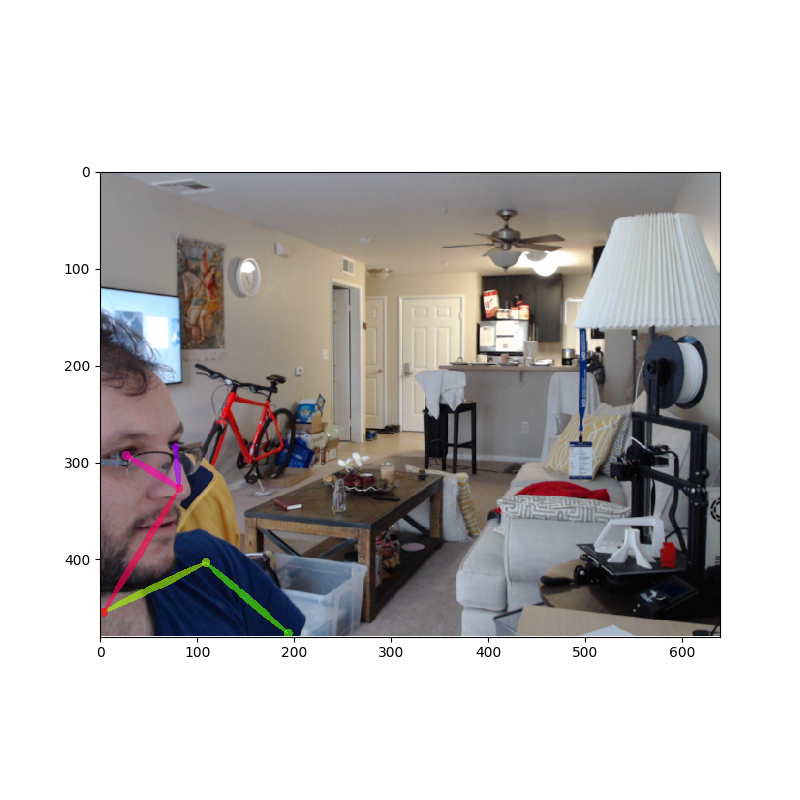

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
%matplotlib notebook

fig = plt.figure(figsize=(8,8), dpi=100)  #figure is 500 pixels wide
ax = fig.add_subplot(111)
plt.axis('off')

# List of variables
width = 10
spacing = 20
bars = int(460/spacing) # make sure bars fit into range
direction = 1

def animate(i):
    global armController
    ret, img = captureLastFrame()
    if ret:
        ax.clear()
        resDatum, degs = processImage(img)
        ax.imshow(cv2.cvtColor(resDatum.cvOutputData, cv2.COLOR_BGR2RGB))
        armController.setDegrees([-1*degs[0],degs[1],0,0])
    

anim = animation.FuncAnimation(fig, animate,
                           frames=20, 
                           interval=10, # control speed with thie interval
                           blit=True)
plt.show()

running=False